# <CENTER><div class="alert alert-block alert-info"><b>Prédiction de la consommation énergétique et de l'émission de bâtiments<br> Prédiction de la consommation totale d'énergie </b><div><CENTER>   
    

### Problématique:
- Prédire les émissions en CO2 et la consommation totale d'énergie de bâtiments pour lesquels elles n'ont pas été mesurées.
- Evaluer l'intérêt de l'"ENERGY STAR Score" pour la prédiction des émissions.  

### Source des jeux de données (un pour l'année 2015 et un pour l'année 2016):
https://www.kaggle.com/datasets/city-of-seattle/sea-building-energy-benchmarking 

### Objectifs:
1. Réaliser une courte analyse exploratoire des jeux de données (Notebook associé)
2. Tester différents modèles de prédiction afin de prédire les émissions de CO2 en se basant sur les données déclaratives du permis d'exploitation commerciale (Notebook associé). 
3. Evaluer l'importance de la variable ENERGY STAR score pour la prédiction des émissions de CO2 (Notebook associé).
4. Tester différents modèles pour prédire la consommation totale d'énergie en se basant sur les données déclaratives du permis d'exploitation commerciale (le présent notebook).

### <a name="C0">Sommaire</a>

- <a href="#C1">1. Importation des librairies nécessaires et définition de fonctions spécifiques</a>
- <a href="#C2">2. Modélisation sans sélection de variables</a>
    - <a href="#C21">2.1. Préparation des données</a>
    - <a href="#C22">2.2. Modélisation de l'émission de CO2</a>
        - <a href="#C221">2.2.1. Approche naïve: Dummyregressor</a>
        - <a href="#C222">2.2.2. Modèle de regression linéaire</a>
        - <a href="#C223">2.2.3. Modèle de regression Elastic Net</a>
        - <a href="#C224">2.2.4. Modèle de random forest</a>
        - <a href="#C225">2.2.5. Modèle xgboost</a>
- <a href="#C3">3. Modélisation avec sélection de variables</a>
    - <a href="#C31">3.1. Préparation du jeu de données</a>
    - <a href="#C32">3.2. Modélisation de l'émission de CO2 avec OneHotEncoder</a>
        - <a href="#C321">3.2.1. Encodage et standardisation des données</a>
        - <a href="#C322">3.2.2. Approche Naive: Dummy Regressor</a>
        - <a href="#C323">3.2.3. Modèle de regression linéaire</a>
        - <a href="#C324">3.2.4. Modèle de random forest</a>
        - <a href="#C325">3.2.5. Modèle xgboost</a>
- <a href="#C4">4. Comparaison des différents modèles et sélection du modèle le plus performant</a></div>
- <a href="#C5">5. Modélisation de l'émission de CO2 avec TargetEncoder</a>
- <a href="#C6">6. Interprétation du modèle XGBoost dans le projet avec la méthode SHAP</a>
    - <a href="#C61">6.1. Mise en place du modèle sélectionné</a>
    - <a href="#C62">6.2. Détermination des valeurs Shap et somme des valeur pour les variables encodées</a>
    - <a href="#C63">6.3.Représentation graphique des valeurs de Shap</a>
- <a href="#C7">7. Impact des propriétés présentes pour 2015 et 2016 pour la prédiction</a>


# <div class="alert alert-block alert-info"><a name="C1">1. Importation des librairies nécessaires et définition de fonctions spécifiques</a></div>

Pour cette partie du projet, nous aurons besoin des librairies : Pandas, Matplotlib, Seaborn et numpy. Nous aurons également besoin de plusieurs fonctions de la librairie Scikit learn.

In [1]:
# Importation des librairies nécessaires
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import time
import warnings
import shap

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
import category_encoders
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import *


warnings.filterwarnings("ignore")

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
print("Dans ce notebook, les versions des packages utilisés sont:")
print("- Pandas", pd.__version__)
print("- matplotlib", matplotlib.__version__)
print("- Seaborn", sns.__version__)
print("- Numpy", np.__version__)
print("- Scikit-learn", sklearn.__version__ )
print("- XGBoost", xgboost.__version__)
print("- Category_encoder", category_encoders.__version__)
print("- Shap", shap.__version__)

Dans ce notebook, les versions des packages utilisés sont:
- Pandas 1.4.2
- matplotlib 3.5.1
- Seaborn 0.11.2
- Numpy 1.21.5
- Scikit-learn 1.0.2
- XGBoost 1.5.0
- Category_encoder 2.2.2
- Shap 0.39.0


**Définition d'une fonction permettant de connaitre le nom des colonnes**

In [3]:
# Fonction pour connaitre le nom des colonnes

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C2">2. Modélisation sans sélection de variables</a></div>

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C21">2.1. Préparation des données</a></div>

In [4]:
# Chargement du jeu de données
data = pd.read_csv('data_pour_model.csv', index_col = 0)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,...,LargestPropertyUseTypeProportion,SecondLargestPropertyUseTypeProportion,ThridLargestPropertyUseTypeProportion,SiteEnergyUse(log(kBtu)),Electricity(%),NaturalGas(%),SteamUse(%),OtherFuelUse(%),PropertyGFAParking(%),PropertyGFABuilding(s)(%)
0,1,NonResidential,Hotel,7,1927,1,12,88434.0,Hotel,Without,...,100.000000,0.000000,0.000000,15.758764,52.799513,18.225326,28.977338,0.0,0.000000,100.000000
1,1,NonResidential,Hotel,7,1927,1,12,88434.0,Hotel,Without,...,100.000000,0.000000,0.000000,15.793246,54.605993,17.663838,27.730162,0.0,0.000000,100.000000
2,2,NonResidential,Hotel,7,1996,1,11,103566.0,Hotel,Parking,...,80.991831,14.545314,4.462855,15.938279,46.747679,53.254248,0.000000,0.0,14.545314,85.454686
3,2,NonResidential,Hotel,7,1996,1,11,103566.0,Hotel,Parking,...,80.991831,14.545314,4.462855,15.942305,38.660907,61.339093,0.000000,0.0,14.545314,85.454686
5,3,NonResidential,Hotel,7,1969,1,41,956110.0,Hotel,Without,...,79.121963,0.000000,0.000000,18.100297,68.230741,2.057944,29.711308,0.0,20.574829,79.425171


In [5]:
data.shape

(2472, 33)

In [6]:
# Connaitre les différentes colonnes et leur types
data.dtypes

OSEBuildingID                               int64
BuildingType                               object
PrimaryPropertyType                        object
CouncilDistrictCode                         int64
YearBuilt                                   int64
NumberofBuildings                           int64
NumberofFloors                              int64
PropertyGFATotal                          float64
LargestPropertyUseType                     object
SecondLargestPropertyUseType               object
ThirdLargestPropertyUseType                object
ENERGYSTARScore                           float64
SiteEnergyUse(kBtu)                       float64
TotalGHGEmissions                         float64
DefaultData                                  bool
ComplianceStatus                           object
Outlier                                    object
Latitude                                  float64
Longitude                                 float64
ZipCode                                   float64


**Modification du jeu de données pour la modélisation**<br>
Afin de faciliter la modélisation:
- changement du Dtype de 'CouncilDistrictCode' et 'ZipCode',
- suppresion des l'ENERGYSTAR Score dont l'implication sera évaluée à la fin du notebook,
- suppression de 'OSEBuildingID' qui n'est pas informatif pour prédire des bâtiments pour lesquels les mesures n'ont pas été réalisées.

In [7]:
# Pour faciliter l'étape de modélisation, je vais attribuer le dtype 'object' au variable qualitative
data[[ 'CouncilDistrictCode', 'ZipCode']] = data[['CouncilDistrictCode', 'ZipCode']].astype(object)

# Suppression de l'ENERGYSTAR Score et de 'OSEBuildingID' pour la prédiction
data_sans = data.drop(columns=['ENERGYSTARScore', 'OSEBuildingID'], axis=1)

print("A présent le jeu de données contient", data_sans.shape[0], "lignes et", data_sans.shape[1], "colonnes")

A présent le jeu de données contient 2472 lignes et 31 colonnes


In [8]:
## Création d'un set de données pour les modèles de machine learning
data_sans_selection = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]

## Pour tester s'il est plus facile d'estimer avec échelle log
echelle = 'log'
#echelle = 'kBtu'

if echelle == 'log':
    y_set = data_sans['SiteEnergyUse(log(kBtu))']
if echelle == 'kBtu':
    y_set= data_sans['SiteEnergyUse(kBtu)']

X_set = data_sans_selection

print("Taille de X_set:", X_set.shape)
print("Taille de y_set:", y_set.shape)

Taille de X_set: (2472, 26)
Taille de y_set: (2472,)


**Encodage et standardisation des données**

In [9]:
# Création de listes avec le nom des variables à encoder ou à standardiser
colonne_encodage = list(X_set.dtypes[X_set.dtypes == object].index)
colonne_standardisation = list(X_set.dtypes[X_set.dtypes != object].index)

# Création d'un transformer
preprocessing = make_column_transformer((RobustScaler(), colonne_standardisation),
                                       (OneHotEncoder(),colonne_encodage))

#Transformation des variables
X_set_std = preprocessing.fit_transform(X_set)

**Préparation d'un jeu de données pour l'entrainement du modèle et d'un jeu de données pour tester le modèle**

In [10]:
# Séparation du training set du testing set
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X_set_std, y_set, train_size = 0.8, random_state=123)

print("Taille des training sets X / y: ",X_train_em.shape,"/", y_train_em.shape)
print("Taille des testing sets X / y: ",X_test_em.shape,"/", y_test_em.shape)

Taille des training sets X / y:  (1977, 164) / (1977,)
Taille des testing sets X / y:  (495, 164) / (495,)


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C22">2.2. Modélisation de la consommation totale d'énergie</a></div>

In [11]:
# Création d'un jeu de données pour rassembler les résultats des différents modèles
results = pd.DataFrame(columns=['Variables sélectionnées','Echelle','Modèle', 'Best_params','Score de la prédiction Xtrain','Score de la prédiction Xtest' ,
                                'RMSE', 'MAE', 'R2','Durée de calcul (msec)'])

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C221">2.2.1. Approche naïve: Dummyregressor</a></div>

In [12]:
# Choix de l'algorithme
dummy_reg = DummyRegressor(strategy="mean")

In [13]:
# Entrainement du modèle

start_time = time.time() # temps de départ pour mesurer la durée de l'entrainement
dummy_reg.fit(X_train_em,y_train_em)
end_time= time.time() # temps de fin pour mesurer la durée de l'entrainement
fitting_time = end_time - start_time # Durée de l'entrainement

#Prédiction sur le jeu test
y_pred_dum = dummy_reg.predict(X_test_em)

# Evaluation du modèle:
print("Méthode: Dummy regressor")

score_ent = dummy_reg.score(X_train_em, y_train_em)
score_pred = dummy_reg.score(X_test_em, y_test_em)
print("Score de la prédiction =", score_pred)

mae = mean_absolute_error(y_test_em, y_pred_dum)
print("MAE = ", mae)

rmse = np.sqrt(mean_squared_error(y_test_em, y_pred_dum))
print("RMSE = ", rmse)

r2 = r2_score(y_test_em,y_pred_dum)
print("R2 = ", r2)

end_time= time.time()
dummy_time = end_time - start_time

# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': ['Sans sélection'],
                            'Echelle': [echelle],
                        'Modèle' : ['Dummy Regressor'],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Dummy regressor
Score de la prédiction = -0.0013050556752638443
MAE =  0.951059467770748
RMSE =  1.2324851958824101
R2 =  -0.0013050556752638443


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C222">2.2.2. Modèle de regression linéaire</a></div>

In [14]:
# Choix de l'algorithme
lin_reg = LinearRegression()

# Entrainement du modèle
start_time = time.time()
lin_reg.fit(X_train_em,y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

# Prédiction sur le jeu de données test
y_pred = lin_reg.predict(X_test_em)

# Evaluation du modèle
print("Méthode: LinearRegression")

score_ent = lin_reg.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = lin_reg.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)


# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': ['Sans sélection'],
                            'Echelle': [echelle],
                        'Modèle' : ['Linear Regression'],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: LinearRegression
Score d'entrainement =  0.6742443303975715
score de la prédiction =  0.6207662257125246
MAE =  0.5832932029534245
RMSE =  0.7584937579572795
R2 =  0.6207662257125246


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C223">2.2.3. Modèle de regression Elastic Net</a></div>

In [15]:
# Définition des hyperparamètres à tester
parametres = {'tol': [0.1, 0.01, 0.001, 0.0001],
             'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
             'l1_ratio':np.arange(0.0, 1.0, 0.2),
              }

In [16]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
elasticnet = GridSearchCV(estimator = ElasticNet(),
                         param_grid = parametres,
                         cv = 5)

# Entrainement du modèle
start_time = time.time()
elasticnet.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [17]:
# Prédiction sur le jeu de données test
y_pred = elasticnet.predict(X_test_em)


# Evaluation du modèle
print("Méthode: Elastic net")

score_ent = elasticnet.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = elasticnet.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)

# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': ['Sans sélection'],
                            'Echelle': [echelle],
                        'Modèle' : ['Elastic Net'],
                             'Best_params': [elasticnet.best_params_],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Elastic net
Score d'entrainement =  0.6628465802369721
score de la prédiction =  0.6258374709354879
MAE =  0.5755807480789022
RMSE =  0.7534052689815645
R2 =  0.6258374709354879


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C224">2.2.4. Modèle de random forest</a></div>

In [18]:
# Définition des hyperparamètres à tester
parameters = {
    'n_estimators' : [100,300,500,600],
    'min_samples_leaf' : [1,5,10], 
    'max_features': ['auto', 'sqrt']}

In [19]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
rfr = GridSearchCV(RandomForestRegressor(),
                              param_grid = parameters,
                              verbose=False,
                              cv=5)
# Entrainement du modèle
start_time = time.time()
rfr.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [20]:
# Prédiction sur le jeu de données test
y_pred = rfr.predict(X_test_em)

# Evaluation du modèle
print("Méthode: Random forest regressor")

score_ent = rfr.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = rfr.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)

# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': ['Sans sélection'],
                            'Echelle': [echelle],
                        'Modèle' : ['Random Forest'],
                             'Best_params': [rfr.best_params_],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Random forest regressor
Score d'entrainement =  0.9776133127772655
score de la prédiction =  0.88452371865399
MAE =  0.2924239087962473
RMSE =  0.41854764426444907
R2 =  0.88452371865399


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C225">2.2.5. Modèle xgboost</a></div>

In [21]:
# Définition des hyperparamètres à tester
parameters = {
    'gamma':[0, 0.5, 1],
    'max_depth': [6, 10, 20],
    'n_estimators' : [100,1000,2000]
}

In [22]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)

# Entrainement du modèle
start_time = time.time()
xgb.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [23]:
# Prédiction sur le jeu de données test
y_pred = xgb.predict(X_test_em)


# Evaluation du modèle
print("Méthode: Xgboost")

score_ent =xgb.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = xgb.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)


# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': ['Sans sélection'],
                            'Echelle': [echelle],
                        'Modèle' : ['XGBoost'],
                             'Best_params': [xgb.best_params_],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Xgboost
Score d'entrainement =  0.9999952527059883
score de la prédiction =  0.9216714813193637
MAE =  0.22850312967329645
RMSE =  0.34471363623256035
R2 =  0.9216714813193637


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C3">3. Modélisation avec sélection de variables</a></div>

## <div class="alert alert-block alert-info"><a name="C31">3.1. Préparation du jeu de données</a></div>

Dans cette partie, plusieurs sélections de variables vont être testées. Le choix des variables s'appuyera sur le module feature_selection de scikit-learn et sur les résultats de l'analyse exploratoire réalisée dans le précédent notebook.
Pour les variables qualitatives, je vais tester avec la suppression des variables qui n'ont pas de corrélation (Calcul de eta carré) avec la variable à prédire c'est-à-dire que je vais supprimer  'SecondLargestPropertyUseType' et 'ThirdLargestPropertyUseType'. Pour les variables DefaultData, ComplianceStatus et Outlier je vais faire le test.
Pour les variables quantitatives, je vais tester la suppression des variables corréler entre elles (supprimer une des deux c'est-à-dire 'NaturalGas(%)', 'PropertyGFAParking(%)' et 'SecondLargestPropertyUseTypeProportion').


In [24]:
selection = 4

if selection == 1:
    # Jeu de données avec suppression de variable par le module feature_selection
    data_avec_selection = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'Latitude', 'Longitude','DefaultData', 'ComplianceStatus', 'Outlier', 
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]
    print(data_avec_selection.shape)
    
if selection == 2:
    # Jeu de données avec suppression de variable par le module feature_selection (suppression de longitute)
    data_avec_selection = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'Latitude', 'Longitude','DefaultData', 'ComplianceStatus', 'Outlier', 
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]
    print(data_avec_selection.shape)

if selection ==3:
    # Jeu de données avec suppression de 'SecondLargestPropertyUseType' et 'ThirdLargestPropertyUseType' 
    # ainsi que 'NaturalGas(%)', 'PropertyGFAParking(%)' et 'SecondLargestPropertyUseTypeProportion',
    # mais en gardant longitude et latitude
    data_avec_selection = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
        'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)',  'SteamUse(%)', 'OtherFuelUse(%)',
        'PropertyGFABuilding(s)(%)']]
    
if selection == 4:
    # Jeu de données avec suppression de variable par le module feature_selection et avec Building Age a la place de YearBuilt
    data_avec_selection = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'BuildingAge', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'Latitude', 'Longitude','DefaultData', 'ComplianceStatus', 'Outlier', 
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]
    print(data_avec_selection.shape)

(2472, 26)


In [25]:
## Création d'un set de données pour les modèles de machine learning
data_model = data_avec_selection

## Pour tester s'il est plus facile d'estimer avec échelle log
echelle = 'log'
#echelle = 'kBtu'

if echelle == 'log':
    y_set = data_sans['SiteEnergyUse(log(kBtu))']
if echelle == 'kBtu':
    y_set= data_sans['SiteEnergyUse(kBtu)']


X_set = data_model

print("Taille de X_set:", X_set.shape)
print("Taille de y_set_emissions:", y_set.shape)

Taille de X_set: (2472, 26)
Taille de y_set_emissions: (2472,)


**Sélection des variables quantitatives**

Pour affiner la sélection des variables quantitatives, je vais utiliser les fonctions VarianceThreshold et SelectKBest de Scikit learn.

In [26]:
# Création d'un jeu de données avec uniquement les variables numériques pour l'estimation de l'émission de CO2
colonne_num = list(X_set.dtypes[(X_set.dtypes != object) & (X_set.dtypes != bool)].index)
X_set_num = X_set[colonne_num]

In [27]:
# Sélection des variables quantitatives avec la fonction de VarianceThreshold
sel_var = VarianceThreshold(threshold=(0.02))
sel_var.fit(X_set_num)

print("Variables sélectionnées:", list(X_set_num.columns[sel_var.get_support()]))
print("Variables pouvant être supprimées:", list(X_set_num.columns[~sel_var.get_support()]))

Variables sélectionnées: ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'NumberOfUse', 'LargestPropertyUseTypeProportion', 'SecondLargestPropertyUseTypeProportion', 'ThridLargestPropertyUseTypeProportion', 'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)', 'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']
Variables pouvant être supprimées: ['Latitude', 'Longitude']


In [28]:
# Sélection des variables quantitatives avec la fonction de SelectKBest
sel_Kbest = SelectKBest(f_regression, k='all')
sel_Kbest.fit(X_set_num, y_set)

print("Selected features:", list(X_set_num.columns[sel_Kbest.get_support()]))
print("Removed features:", list(X_set_num.columns[~sel_Kbest.get_support()]))

Selected features: ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Latitude', 'Longitude', 'NumberOfUse', 'LargestPropertyUseTypeProportion', 'SecondLargestPropertyUseTypeProportion', 'ThridLargestPropertyUseTypeProportion', 'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)', 'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']
Removed features: []


Seule l'utilisation du module VarianceThreshold enlève des variables. Je vais modifier le X_set pour supprimer les variables sélectionner.

In [29]:
X_set_num2 = sel_var.transform(X_set_num)

# Conversion en dataframe
X_set_num3 = pd.DataFrame(X_set_num2, index=X_set_num.index, columns=X_set_num.columns[sel_var.get_support()])
X_set_num3.shape

(2472, 14)

In [30]:
# Préparation d'un jeu X pour l'estimation de l'emission de CO2
X_select = X_set.drop(columns=colonne_num, axis = 1)

X_select = pd.concat([X_select, X_set_num3], axis=1)
X_select.shape

(2472, 24)

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C32">3.2. Modélisation de la consommation totale d'énergie avec OneHotEncoder</a></div>

### <div class="alert alert-block alert-info"><a name="C321">3.2.1. Encodage et standardisation des données</a></div>

In [31]:
# Création de listes avec le nom des variables à encoder ou à standardiser
colonne_encodage = list(X_set.dtypes[X_set.dtypes == object].index)
colonne_standardisation = list(X_set.dtypes[X_set.dtypes != object].index)

# Création d'un transformer
preprocessing = make_column_transformer((RobustScaler(), colonne_standardisation),
                                       (OneHotEncoder(),colonne_encodage))

#Transformation des variables
X_set_std = preprocessing.fit_transform(X_set)

In [32]:
# Séparation du training set du testing set
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X_set_std, y_set, train_size = 0.8, random_state=123)

print("Taille des training sets X / y: ",X_train_em.shape,"/", y_train_em.shape)
print("Taille des testing sets X / y: ",X_test_em.shape,"/", y_test_em.shape)

Taille des training sets X / y:  (1977, 164) / (1977,)
Taille des testing sets X / y:  (495, 164) / (495,)


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C322">3.2.2. Approche Naive: Dummy Regressor</a></div>

In [33]:
dummy_reg = DummyRegressor(strategy="mean")

In [34]:
# Entrainement du modèle
start_time = time.time()# temps de départ pour mesurer la durée de l'entrainement
dummy_reg.fit(X_train_em,y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

#Prédiction sur le jeu test
y_pred_dum = dummy_reg.predict(X_test_em)

# Evaluation du modèle:
print("Méthode: Dummy regressor")

score_ent = dummy_reg.score(X_train_em, y_train_em)
score_pred = dummy_reg.score(X_test_em, y_test_em)
print("Score de la prédiction =", score_pred)

mae = mean_absolute_error(y_test_em, y_pred_dum)
print("MAE = ", mae)

rmse = np.sqrt(mean_squared_error(y_test_em, y_pred_dum))
print("RMSE = ", rmse)

r2 = r2_score(y_test_em,y_pred_dum)
print("R2 = ", r2)

end_time= time.time()
dummy_time = end_time - start_time

#Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': [selection],
                            'Echelle': [echelle],
                        'Modèle' : ['Dummy regressor'],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])


Méthode: Dummy regressor
Score de la prédiction = -0.0013050556752638443
MAE =  0.951059467770748
RMSE =  1.2324851958824101
R2 =  -0.0013050556752638443


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C323">3.2.3. Modèle de regression linéaire</a></div>

In [35]:
# Choix de l'algorithme
lin_reg = LinearRegression()

# Entrainement du modèle
start_time = time.time()
lin_reg.fit(X_train_em,y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

# Prédiction sur le jeu de données test
y_pred = lin_reg.predict(X_test_em)


# Evaluation du modèle
print("Méthode: LinearRegression")

score_ent = lin_reg.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = lin_reg.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)


# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': [selection],
                            'Echelle': [echelle],
                        'Modèle' : ['Linear regression'],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])


Méthode: LinearRegression
Score d'entrainement =  0.6742363302437469
score de la prédiction =  0.6207433006465168
MAE =  0.5834209778392975
RMSE =  0.7585166834690167
R2 =  0.6207433006465168


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C324">3.2.4. Modèle de random forest</a></div>

In [36]:
# Définition des hyperparamètres à tester
parameters = {
    'n_estimators' : [100,300,500,600],
    'min_samples_leaf' : [1,5,10], 
    'max_features': ['auto', 'sqrt']}

In [37]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
rfr = GridSearchCV(RandomForestRegressor(),
                              param_grid = parameters,
                              verbose=False,
                              cv=5)

# Entrainement du modèle
start_time = time.time()
rfr.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [38]:
# Prédiction sur le jeu de données test
y_pred = rfr.predict(X_test_em)


# Evaluation du modèle

print("Méthode: Random forest regressor")

score_ent = rfr.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = rfr.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)



# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': [selection],
                            'Echelle': [echelle],
                        'Modèle' : ['Random Forest'],
                             'Best_params': [rfr.best_params_],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Random forest regressor
Score d'entrainement =  0.9776669738615598
score de la prédiction =  0.8831556183226239
MAE =  0.29339785992549966
RMSE =  0.42101970661612526
R2 =  0.8831556183226239


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


### <div class="alert alert-block alert-info"><a name="C325">3.2.5. Modèle xgboost</a></div>

In [39]:
# Définition des hyperparamètres à tester
parameters = {
    'gamma':[0, 0.5, 1],
    'max_depth': [6, 10, 20],
    'n_estimators' : [100,1000,2000]
    }

In [40]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)

# Entrainement du modèle
start_time = time.time()
xgb.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [41]:
# Prédiction sur le jeu de données test
y_pred = xgb.predict(X_test_em)


# Evaluation du modèle
print("Méthode: Xgboost")

score_ent =xgb.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = xgb.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)


# Pour mettre dans results
result_model = pd.DataFrame({'Variables sélectionnées': [selection],
                            'Echelle': [echelle],
                        'Modèle' : ['XGBoost'],
                             'Best_params': [xgb.best_params_],
                         'Score de la prédiction Xtrain': [score_ent],
                          'Score de la prédiction Xtest': [score_pred],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'R2':[r2],
                          'Durée de calcul (msec)':[fitting_time]})

results = pd.concat([results, result_model])

Méthode: Xgboost
Score d'entrainement =  0.9999968558440705
score de la prédiction =  0.9065174654681379
MAE =  0.24627371112266105
RMSE =  0.37658563202702633
R2 =  0.9065174654681379


<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C4">4. Comparaison des différents modèles et sélection du modèle le plus performant</a></div>

In [42]:
results

,Variables sélectionnées,Echelle,Modèle,Best_params,Score de la prédiction Xtrain,Score de la prédiction Xtest,RMSE,MAE,R2,Durée de calcul (msec)
0,Sans sélection,log,Dummy Regressor,NaN,0.0,-0.001305,1.232485,0.951059,-0.001305,0.0
0,Sans sélection,log,Linear Regression,NaN,0.674244,0.620766,0.758494,0.583293,0.620766,0.094198
0,Sans sélection,log,Elastic Net,"{'alpha': 0.001, 'l1_ratio': 0.600000000000000...",0.662847,0.625837,0.753405,0.575581,0.625837,185.201721
0,Sans sélection,log,Random Forest,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.977613,0.884524,0.418548,0.292424,0.884524,787.772286
0,Sans sélection,log,XGBoost,"{'gamma': 0, 'max_depth': 6, 'n_estimators': 1...",0.999995,0.921671,0.344714,0.228503,0.921671,583.894007
0,4,log,Dummy regressor,NaN,0.0,-0.001305,1.232485,0.951059,-0.001305,0.000807
0,4,log,Linear regression,NaN,0.674236,0.620743,0.758517,0.583421,0.620743,0.085824
0,4,log,Random Forest,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.977667,0.883156,0.42102,0.293398,0.883156,807.131829
0,4,log,XGBoost,"{'gamma': 0, 'max_depth': 6, 'n_estimators': 1...",0.999997,0.906517,0.376586,0.246274,0.906517,698.758845


In [43]:
# Sauvgarde des résultats au format csv
results.to_csv("resultat_modélisation_consommation1.csv")


Afin de savoir quel est le modèle le plus performant, je vais charger le fichier CSV qui contient tout les résultats de modèlisation et afficher celui qui obtient le meilleur score avec le jeu de données test (R2 le plus proche de 1)

In [44]:
# Chargement du fichier csv qui contient tout les résultats
data_results = pd.read_csv("resultat_modélisation_consommation.csv")

In [45]:
# Pour afficher le meilleur résulat (R2 le plus proche de 1)
data_results.iloc[data_results['R2'].idxmax(),:]

Unnamed: 0                                                                       0
Variables sélectionnées                                             Sans sélection
Echelle                                                                        log
Modèle                                                                     XGBoost
Best_params                      {'gamma': 0, 'max_depth': 6, 'n_estimators': 1...
Score de la prédiction Xtrain                                             0.999995
Score de la prédiction Xtest                                              0.921671
RMSE                                                                      0.344714
MAE                                                                       0.228503
R2                                                                        0.921671
Durée de calcul (msec)                                                    0.006232
Name: 25, dtype: object

Lors des différentes modélisations de la consommation totale d'énergie, j'ai éssayé avec ou sans sélection de variables et de prédire les émissions soit en échelle classique soit en échelle logarithmique.<br>
Le meilleur résultat est obtenu sans sélection de variables pour l'échelle logarithmique avec l'algorithme XGBoost.
Est-il possible d'obtenir un meilleur score avec TargetEncoder à la place du OneHotEncoder pour les variables qualitatives?

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C5">5. Modélisation de la consommation totale d'énergie avec TargetEncoder</a></div>

**Préparation du jeu de données** 

In [46]:
X_set = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]


y_set = data_sans['SiteEnergyUse(log(kBtu))']

# Séparation du training set du testing set
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, train_size = 0.8, random_state=123, shuffle=True)

print("Taille des training sets X / y: ",X_train.shape,"/", y_train.shape)
print("Taille des testing sets X / y: ",X_test.shape,"/", y_test.shape)

Taille des training sets X / y:  (1977, 26) / (1977,)
Taille des testing sets X / y:  (495, 26) / (495,)


**Encodage et standardisation des données**

In [47]:
# Différenciation des variables quantitatives et qualitatives
colonne_encodage = list(X_set.dtypes[X_set.dtypes == object].index)
colonne_standardisation = list(X_set.dtypes[X_set.dtypes != object].index)

# Préparation des "transformers"
preprocessing = make_column_transformer((RobustScaler(), colonne_standardisation),
                                       (TargetEncoder(),colonne_encodage))

**Mise en place d'un pipeline pour la transformation des données et la sélection du modèle**

In [48]:
# Mise en place d'un pipeline pour faire l'encodage et la modélisation
pipeline = make_pipeline(preprocessing,XGBRegressor())

In [49]:
# Définition des hyperparamétres à tester
parameters = {
    'xgbregressor__gamma':[0, 0.5, 1],
    'xgbregressor__max_depth': [6, 10, 20],
    'xgbregressor__n_estimators' : [100,1000,2000]
    }

In [50]:
# Mise en place de gridSearchCV pour déterminer les meilleurs hyperparamètres
grid = GridSearchCV(pipeline,
                        param_grid = parameters,
                        cv = 5,
                        )

In [51]:
# Entrainement du modèle
start_time = time.time()
grid.fit(X_train,y_train)
end_time= time.time()
fitting_time = end_time - start_time

In [52]:
# Prédiction sur le jeu de données test
y_pred = grid.predict(X_test)

# Evaluation du modèle
print("Méthode: Xgboost avec TargetEncoder")

score_ent =grid.score(X_train,y_train)
print("Score d'entrainement = ", score_ent)

score_pred = grid.score(X_test, y_test)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test,y_pred)
print("R2 = ", r2)

print("Durée du fit=",fitting_time)

Méthode: Xgboost avec TargetEncoder
Score d'entrainement =  0.999997303795065
score de la prédiction =  0.9058721104131274
MAE =  0.23377335993058915
RMSE =  0.3778832725073469
R2 =  0.9058721104131274
Durée du fit= 631.6291399002075


L'utilisation du TargetEncoder à la place du OneHotEncoder n'améliore pas les performances du modèle puisque cette fois-ci un score de 90,6% a été obtenue au lieu de 92,2%

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C6">6. Interprétation du modèle XGBoost dans le projet avec la méthode SHAP</a></div>

Pour connaitre l'importance de nos différentes variables pour la modélisation, je vais utiliser le module SHAP qui détermine la valeur sphapley de chaque variable sur la modèle XGBoost sans sélection de variable avec le OneHotEncoder.

## <div class="alert alert-block alert-info"><a name="C61">6.1. Mise en place du modèle sélectionné</a></div>

In [53]:
data_sans.reset_index(drop=True,inplace=True)

In [54]:
X_set = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'ZipCode', 'NumberOfUse', 
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]

y_set = data_sans['SiteEnergyUse(log(kBtu))']

In [55]:
# Encodage et standardisation des données

colonne_encodage = list(X_set.dtypes[X_set.dtypes == object].index)
colonne_standardisation = list(X_set.dtypes[X_set.dtypes != object].index)

preprocessing = ColumnTransformer([('scaler',RobustScaler(), colonne_standardisation),
                                       ('onehot',OneHotEncoder(),colonne_encodage)])


X_set_std = preprocessing.fit_transform(X_set)

In [56]:
# Séparation du training set du testing set
X_train, X_test, y_train, y_test = train_test_split(X_set_std, y_set, train_size = 0.8, random_state=123, shuffle=True)

print("Taille des training sets X / y: ",X_train.shape,"/", y_train.shape)
print("Taille des testing sets X / y: ",X_test.shape,"/", y_test.shape)

Taille des training sets X / y:  (1977, 164) / (1977,)
Taille des testing sets X / y:  (495, 164) / (495,)


In [57]:
model_select = XGBRegressor(gamma=0, max_depth=6, n_estimators=1000)

start_time = time.time()
model_select.fit(X_train, y_train)
end_time= time.time()
fitting_time = end_time - start_time

In [58]:
# Prédiction sur le jeu de données test
y_pred = model_select.predict(X_test)

# Evaluation du modèle
print("Méthode: Xgboost")

score_ent =model_select.score(X_train,y_train)
print("Score d'entrainement = ", score_ent)

score_pred = model_select.score(X_test, y_test)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test,y_pred)
print("R2 = ", r2)

print("Durée du fit=",fitting_time)

Méthode: Xgboost
Score d'entrainement =  0.9999952527059883
score de la prédiction =  0.9216714813193637
MAE =  0.22850312967329645
RMSE =  0.34471363623256035
R2 =  0.9216714813193637
Durée du fit= 1.8863000869750977


On retrouve bien le même résultat.
Maintenant, je souhaite savoir quelles variables sont les plus importantes pour la prédiction. Pour cela, je vais utiliser le module shap.
Avant de pouvoir utiliser Shap, je vais remettre sous forme de dataframe mon jeu de données.

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C62">6.2. Détermination des valeurs Shap et somme des valeur pour les variables encodées</a></div>

In [59]:
# Récupération d'une liste des noms des colonnes après l'encodage
nom_colonnes = get_feature_names(preprocessing)
nom_colonnes

['scaler__YearBuilt',
 'scaler__NumberofBuildings',
 'scaler__NumberofFloors',
 'scaler__PropertyGFATotal',
 'scaler__DefaultData',
 'scaler__Latitude',
 'scaler__Longitude',
 'scaler__NumberOfUse',
 'scaler__LargestPropertyUseTypeProportion',
 'scaler__SecondLargestPropertyUseTypeProportion',
 'scaler__ThridLargestPropertyUseTypeProportion',
 'scaler__Electricity(%)',
 'scaler__NaturalGas(%)',
 'scaler__SteamUse(%)',
 'scaler__OtherFuelUse(%)',
 'scaler__PropertyGFAParking(%)',
 'scaler__PropertyGFABuilding(s)(%)',
 'onehot__x0_Campus',
 'onehot__x0_NonResidential',
 'onehot__x0_Nonresidential COS',
 'onehot__x0_Nonresidential WA',
 'onehot__x0_SPS-District K-12',
 'onehot__x1_Distribution Center',
 'onehot__x1_Education',
 'onehot__x1_Hospital',
 'onehot__x1_Hotel',
 'onehot__x1_Laboratory',
 'onehot__x1_Medical Office',
 'onehot__x1_Mixed Use Property',
 'onehot__x1_Office',
 'onehot__x1_Other',
 'onehot__x1_Refrigerated Warehouse',
 'onehot__x1_Residence Hall',
 'onehot__x1_Restaur

In [60]:
# X_set_std est remis sous forme de dataframe
X_std_df = pd.DataFrame(X_set_std.todense(), index=X_set.index, columns=[
    'scaler__YearBuilt','scaler__NumberofBuildings','scaler__NumberofFloors','scaler__PropertyGFATotal','scaler__DefaultData','scaler__Latitude','scaler__Longitude','scaler__NumberOfUse','scaler__LargestPropertyUseTypeProportion','scaler__SecondLargestPropertyUseTypeProportion','scaler__ThridLargestPropertyUseTypeProportion','scaler__Electricity(%)','scaler__NaturalGas(%)','scaler__SteamUse(%)','scaler__OtherFuelUse(%)','scaler__PropertyGFAParking(%)','scaler__PropertyGFABuilding(s)(%)',
    'onehot__BuildingType_Campus','onehot__BuildingType_NonResidential','onehot__BuildingType_Nonresidential COS','onehot__BuildingType_Nonresidential WA','onehot__BuildingType_SPS-District K-12',
    'onehot__PrimaryPropertyType_Distribution Center','onehot__PrimaryPropertyType_Education','onehot__PrimaryPropertyType_Hospital','onehot__PrimaryPropertyType_Hotel','onehot__PrimaryPropertyType_Laboratory','onehot__PrimaryPropertyType_Medical Office','onehot__PrimaryPropertyType_Mixed Use Property','onehot__PrimaryPropertyType_Office','onehot__PrimaryPropertyType_Other','onehot__PrimaryPropertyType_Refrigerated Warehouse','onehot__PrimaryPropertyType_Residence Hall','onehot__PrimaryPropertyType_Restaurant','onehot__PrimaryPropertyType_Retail Store','onehot__PrimaryPropertyType_Self-Storage Facility','onehot__PrimaryPropertyType_Senior Care Community','onehot__PrimaryPropertyType_Supermarket/Grocery Store','onehot__PrimaryPropertyType_Warehouse','onehot__PrimaryPropertyType_Worship Facility',
    'onehot__CouncilDistrictCode_1','onehot__CouncilDistrictCode_2','onehot__CouncilDistrictCode_3','onehot__CouncilDistrictCode_4','onehot__CouncilDistrictCode_5','onehot__CouncilDistrictCode_6','onehot__CouncilDistrictCode_7',
    'onehot__LargestPropertyUseType_Data Center','onehot__LargestPropertyUseType_Distribution Center','onehot__LargestPropertyUseType_Education','onehot__LargestPropertyUseType_Entertainment', 'onehot__LargestPropertyUseType_Hospital/Residential Care Facility','onehot__LargestPropertyUseType_Hotel','onehot__LargestPropertyUseType_Laboratory','onehot__LargestPropertyUseType_Manufacturing/Industrial Plant','onehot__LargestPropertyUseType_Meeting Hall','onehot__LargestPropertyUseType_Mixed Use Property','onehot__LargestPropertyUseType_Multifamily Housing','onehot__LargestPropertyUseType_Office','onehot__LargestPropertyUseType_Other','onehot__LargestPropertyUseType_Parking','onehot__LargestPropertyUseType_Prison/Incarceration','onehot__LargestPropertyUseType_Public service','onehot__LargestPropertyUseType_Refrigerated Warehouse','onehot__LargestPropertyUseType_Residence Hall','onehot__LargestPropertyUseType_Restaurant/Bar','onehot__LargestPropertyUseType_Retail Store','onehot__LargestPropertyUseType_Self-Storage Facility','onehot__LargestPropertyUseType_Senior Care Community','onehot__LargestPropertyUseType_Sport center','onehot__LargestPropertyUseType_Supermarket/Grocery Store','onehot__LargestPropertyUseType_Warehouse','onehot__LargestPropertyUseType_Worship Facility',
    'onehot__SecondLargestPropertyUseType_Data Center','onehot__SecondLargestPropertyUseType_Distribution Center','onehot__SecondLargestPropertyUseType_Education','onehot__SecondLargestPropertyUseType_Entertainment','onehot__SecondLargestPropertyUseType_Hospital/Residential Care Facility','onehot__SecondLargestPropertyUseType_Hotel','onehot__SecondLargestPropertyUseType_Laboratory','onehot__SecondLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__SecondLargestPropertyUseType_Multifamily Housing','onehot__SecondLargestPropertyUseType_Office','onehot__SecondLargestPropertyUseType_Other','onehot__SecondLargestPropertyUseType_Parking','onehot__SecondLargestPropertyUseType_Public service','onehot__SecondLargestPropertyUseType_Refrigerated Warehouse','onehot__SecondLargestPropertyUseType_Residence Hall','onehot__SecondLargestPropertyUseType_Restaurant/Bar','onehot__SecondLargestPropertyUseType_Retail Store','onehot__SecondLargestPropertyUseType_Self-Storage Facility','onehot__SecondLargestPropertyUseType_Sport center','onehot__SecondLargestPropertyUseType_Supermarket/Grocery Store','onehot__SecondLargestPropertyUseType_Warehouse','onehot__SecondLargestPropertyUseType_Without','onehot__SecondLargestPropertyUseType_Worship Facility',
    'onehot__ThirdLargestPropertyUseType_Data Center','onehot__ThirdLargestPropertyUseType_Distribution Center','onehot__ThirdLargestPropertyUseType_Education','onehot__ThirdLargestPropertyUseType_Entertainment','onehot__ThirdLargestPropertyUseType_Hospital/Residential Care Facility','onehot__ThirdLargestPropertyUseType_Laboratory','onehot__ThirdLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__ThirdLargestPropertyUseType_Meeting Hall','onehot__ThirdLargestPropertyUseType_Multifamily Housing','onehot__ThirdLargestPropertyUseType_Office','onehot__ThirdLargestPropertyUseType_Other','onehot__ThirdLargestPropertyUseType_Parking','onehot__ThirdLargestPropertyUseType_Refrigerated Warehouse','onehot__ThirdLargestPropertyUseType_Restaurant/Bar','onehot__ThirdLargestPropertyUseType_Retail Store','onehot__ThirdLargestPropertyUseType_Self-Storage Facility','onehot__ThirdLargestPropertyUseType_Sport center','onehot__ThirdLargestPropertyUseType_Supermarket/Grocery Store','onehot__ThirdLargestPropertyUseType_Warehouse','onehot__ThirdLargestPropertyUseType_Without',
    'onehot__ComplianceStatus_Compliant','onehot__ComplianceStatus_Error - Correct Default Data','onehot__ComplianceStatus_Non-Compliant',
    'onehot__Outlier_High Outlier','onehot__Outlier_Low Outlier','onehot__Outlier_Not outlier',
    'onehot__ZipCode_98006.0','onehot__ZipCode_98011.0','onehot__ZipCode_98013.0','onehot__ZipCode_98020.0','onehot__ZipCode_98033.0','onehot__ZipCode_98070.0','onehot__ZipCode_98101.0','onehot__ZipCode_98102.0','onehot__ZipCode_98103.0','onehot__ZipCode_98104.0','onehot__ZipCode_98105.0','onehot__ZipCode_98106.0','onehot__ZipCode_98107.0','onehot__ZipCode_98108.0','onehot__ZipCode_98109.0','onehot__ZipCode_98111.0','onehot__ZipCode_98112.0','onehot__ZipCode_98113.0','onehot__ZipCode_98115.0','onehot__ZipCode_98116.0','onehot__ZipCode_98117.0','onehot__ZipCode_98118.0','onehot__ZipCode_98119.0','onehot__ZipCode_98121.0','onehot__ZipCode_98122.0','onehot__ZipCode_98124.0','onehot__ZipCode_98125.0','onehot__ZipCode_98126.0','onehot__ZipCode_98133.0','onehot__ZipCode_98134.0','onehot__ZipCode_98136.0','onehot__ZipCode_98144.0','onehot__ZipCode_98145.0','onehot__ZipCode_98146.0','onehot__ZipCode_98154.0','onehot__ZipCode_98155.0','onehot__ZipCode_98165.0','onehot__ZipCode_98177.0','onehot__ZipCode_98178.0','onehot__ZipCode_98185.0','onehot__ZipCode_98195.0','onehot__ZipCode_98199.0'])


In [61]:
shap.initjs()

In [62]:
explainer = shap.Explainer(model_select)
shap_values = explainer.shap_values(X_test)

In [63]:
shap_values.shape

(495, 164)

In [64]:
# Mettre les shap_values dans un dataframe
shap_df = pd.DataFrame(shap_values,  columns=[
    'scaler__YearBuilt','scaler__NumberofBuildings','scaler__NumberofFloors','scaler__PropertyGFATotal','scaler__DefaultData','scaler__Latitude','scaler__Longitude','scaler__NumberOfUse','scaler__LargestPropertyUseTypeProportion','scaler__SecondLargestPropertyUseTypeProportion','scaler__ThridLargestPropertyUseTypeProportion','scaler__Electricity(%)','scaler__NaturalGas(%)','scaler__SteamUse(%)','scaler__OtherFuelUse(%)','scaler__PropertyGFAParking(%)','scaler__PropertyGFABuilding(s)(%)',
    'onehot__BuildingType_Campus','onehot__BuildingType_NonResidential','onehot__BuildingType_Nonresidential COS','onehot__BuildingType_Nonresidential WA','onehot__BuildingType_SPS-District K-12',
    'onehot__PrimaryPropertyType_Distribution Center','onehot__PrimaryPropertyType_Education','onehot__PrimaryPropertyType_Hospital','onehot__PrimaryPropertyType_Hotel','onehot__PrimaryPropertyType_Laboratory','onehot__PrimaryPropertyType_Medical Office','onehot__PrimaryPropertyType_Mixed Use Property','onehot__PrimaryPropertyType_Office','onehot__PrimaryPropertyType_Other','onehot__PrimaryPropertyType_Refrigerated Warehouse','onehot__PrimaryPropertyType_Residence Hall','onehot__PrimaryPropertyType_Restaurant','onehot__PrimaryPropertyType_Retail Store','onehot__PrimaryPropertyType_Self-Storage Facility','onehot__PrimaryPropertyType_Senior Care Community','onehot__PrimaryPropertyType_Supermarket/Grocery Store','onehot__PrimaryPropertyType_Warehouse','onehot__PrimaryPropertyType_Worship Facility',
    'onehot__CouncilDistrictCode_1','onehot__CouncilDistrictCode_2','onehot__CouncilDistrictCode_3','onehot__CouncilDistrictCode_4','onehot__CouncilDistrictCode_5','onehot__CouncilDistrictCode_6','onehot__CouncilDistrictCode_7',
    'onehot__LargestPropertyUseType_Data Center','onehot__LargestPropertyUseType_Distribution Center','onehot__LargestPropertyUseType_Education','onehot__LargestPropertyUseType_Entertainment', 'onehot__LargestPropertyUseType_Hospital/Residential Care Facility','onehot__LargestPropertyUseType_Hotel','onehot__LargestPropertyUseType_Laboratory','onehot__LargestPropertyUseType_Manufacturing/Industrial Plant','onehot__LargestPropertyUseType_Meeting Hall','onehot__LargestPropertyUseType_Mixed Use Property','onehot__LargestPropertyUseType_Multifamily Housing','onehot__LargestPropertyUseType_Office','onehot__LargestPropertyUseType_Other','onehot__LargestPropertyUseType_Parking','onehot__LargestPropertyUseType_Prison/Incarceration','onehot__LargestPropertyUseType_Public service','onehot__LargestPropertyUseType_Refrigerated Warehouse','onehot__LargestPropertyUseType_Residence Hall','onehot__LargestPropertyUseType_Restaurant/Bar','onehot__LargestPropertyUseType_Retail Store','onehot__LargestPropertyUseType_Self-Storage Facility','onehot__LargestPropertyUseType_Senior Care Community','onehot__LargestPropertyUseType_Sport center','onehot__LargestPropertyUseType_Supermarket/Grocery Store','onehot__LargestPropertyUseType_Warehouse','onehot__LargestPropertyUseType_Worship Facility',
    'onehot__SecondLargestPropertyUseType_Data Center','onehot__SecondLargestPropertyUseType_Distribution Center','onehot__SecondLargestPropertyUseType_Education','onehot__SecondLargestPropertyUseType_Entertainment','onehot__SecondLargestPropertyUseType_Hospital/Residential Care Facility','onehot__SecondLargestPropertyUseType_Hotel','onehot__SecondLargestPropertyUseType_Laboratory','onehot__SecondLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__SecondLargestPropertyUseType_Multifamily Housing','onehot__SecondLargestPropertyUseType_Office','onehot__SecondLargestPropertyUseType_Other','onehot__SecondLargestPropertyUseType_Parking','onehot__SecondLargestPropertyUseType_Public service','onehot__SecondLargestPropertyUseType_Refrigerated Warehouse','onehot__SecondLargestPropertyUseType_Residence Hall','onehot__SecondLargestPropertyUseType_Restaurant/Bar','onehot__SecondLargestPropertyUseType_Retail Store','onehot__SecondLargestPropertyUseType_Self-Storage Facility','onehot__SecondLargestPropertyUseType_Sport center','onehot__SecondLargestPropertyUseType_Supermarket/Grocery Store','onehot__SecondLargestPropertyUseType_Warehouse','onehot__SecondLargestPropertyUseType_Without','onehot__SecondLargestPropertyUseType_Worship Facility',
    'onehot__ThirdLargestPropertyUseType_Data Center','onehot__ThirdLargestPropertyUseType_Distribution Center','onehot__ThirdLargestPropertyUseType_Education','onehot__ThirdLargestPropertyUseType_Entertainment','onehot__ThirdLargestPropertyUseType_Hospital/Residential Care Facility','onehot__ThirdLargestPropertyUseType_Laboratory','onehot__ThirdLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__ThirdLargestPropertyUseType_Meeting Hall','onehot__ThirdLargestPropertyUseType_Multifamily Housing','onehot__ThirdLargestPropertyUseType_Office','onehot__ThirdLargestPropertyUseType_Other','onehot__ThirdLargestPropertyUseType_Parking','onehot__ThirdLargestPropertyUseType_Refrigerated Warehouse','onehot__ThirdLargestPropertyUseType_Restaurant/Bar','onehot__ThirdLargestPropertyUseType_Retail Store','onehot__ThirdLargestPropertyUseType_Self-Storage Facility','onehot__ThirdLargestPropertyUseType_Sport center','onehot__ThirdLargestPropertyUseType_Supermarket/Grocery Store','onehot__ThirdLargestPropertyUseType_Warehouse','onehot__ThirdLargestPropertyUseType_Without',
    'onehot__ComplianceStatus_Compliant','onehot__ComplianceStatus_Error - Correct Default Data','onehot__ComplianceStatus_Non-Compliant',
    'onehot__Outlier_High Outlier','onehot__Outlier_Low Outlier','onehot__Outlier_Not outlier',
    'onehot__ZipCode_98006.0','onehot__ZipCode_98011.0','onehot__ZipCode_98013.0','onehot__ZipCode_98020.0','onehot__ZipCode_98033.0','onehot__ZipCode_98070.0','onehot__ZipCode_98101.0','onehot__ZipCode_98102.0','onehot__ZipCode_98103.0','onehot__ZipCode_98104.0','onehot__ZipCode_98105.0','onehot__ZipCode_98106.0','onehot__ZipCode_98107.0','onehot__ZipCode_98108.0','onehot__ZipCode_98109.0','onehot__ZipCode_98111.0','onehot__ZipCode_98112.0','onehot__ZipCode_98113.0','onehot__ZipCode_98115.0','onehot__ZipCode_98116.0','onehot__ZipCode_98117.0','onehot__ZipCode_98118.0','onehot__ZipCode_98119.0','onehot__ZipCode_98121.0','onehot__ZipCode_98122.0','onehot__ZipCode_98124.0','onehot__ZipCode_98125.0','onehot__ZipCode_98126.0','onehot__ZipCode_98133.0','onehot__ZipCode_98134.0','onehot__ZipCode_98136.0','onehot__ZipCode_98144.0','onehot__ZipCode_98145.0','onehot__ZipCode_98146.0','onehot__ZipCode_98154.0','onehot__ZipCode_98155.0','onehot__ZipCode_98165.0','onehot__ZipCode_98177.0','onehot__ZipCode_98178.0','onehot__ZipCode_98185.0','onehot__ZipCode_98195.0','onehot__ZipCode_98199.0'])


# Mettre X_test sous forme de dataframe
X_test_df = pd.DataFrame(X_test.todense(),columns=[
    'scaler__YearBuilt','scaler__NumberofBuildings','scaler__NumberofFloors','scaler__PropertyGFATotal','scaler__DefaultData','scaler__Latitude','scaler__Longitude','scaler__NumberOfUse','scaler__LargestPropertyUseTypeProportion','scaler__SecondLargestPropertyUseTypeProportion','scaler__ThridLargestPropertyUseTypeProportion','scaler__Electricity(%)','scaler__NaturalGas(%)','scaler__SteamUse(%)','scaler__OtherFuelUse(%)','scaler__PropertyGFAParking(%)','scaler__PropertyGFABuilding(s)(%)',
    'onehot__BuildingType_Campus','onehot__BuildingType_NonResidential','onehot__BuildingType_Nonresidential COS','onehot__BuildingType_Nonresidential WA','onehot__BuildingType_SPS-District K-12',
    'onehot__PrimaryPropertyType_Distribution Center','onehot__PrimaryPropertyType_Education','onehot__PrimaryPropertyType_Hospital','onehot__PrimaryPropertyType_Hotel','onehot__PrimaryPropertyType_Laboratory','onehot__PrimaryPropertyType_Medical Office','onehot__PrimaryPropertyType_Mixed Use Property','onehot__PrimaryPropertyType_Office','onehot__PrimaryPropertyType_Other','onehot__PrimaryPropertyType_Refrigerated Warehouse','onehot__PrimaryPropertyType_Residence Hall','onehot__PrimaryPropertyType_Restaurant','onehot__PrimaryPropertyType_Retail Store','onehot__PrimaryPropertyType_Self-Storage Facility','onehot__PrimaryPropertyType_Senior Care Community','onehot__PrimaryPropertyType_Supermarket/Grocery Store','onehot__PrimaryPropertyType_Warehouse','onehot__PrimaryPropertyType_Worship Facility',
    'onehot__CouncilDistrictCode_1','onehot__CouncilDistrictCode_2','onehot__CouncilDistrictCode_3','onehot__CouncilDistrictCode_4','onehot__CouncilDistrictCode_5','onehot__CouncilDistrictCode_6','onehot__CouncilDistrictCode_7',
    'onehot__LargestPropertyUseType_Data Center','onehot__LargestPropertyUseType_Distribution Center','onehot__LargestPropertyUseType_Education','onehot__LargestPropertyUseType_Entertainment', 'onehot__LargestPropertyUseType_Hospital/Residential Care Facility','onehot__LargestPropertyUseType_Hotel','onehot__LargestPropertyUseType_Laboratory','onehot__LargestPropertyUseType_Manufacturing/Industrial Plant','onehot__LargestPropertyUseType_Meeting Hall','onehot__LargestPropertyUseType_Mixed Use Property','onehot__LargestPropertyUseType_Multifamily Housing','onehot__LargestPropertyUseType_Office','onehot__LargestPropertyUseType_Other','onehot__LargestPropertyUseType_Parking','onehot__LargestPropertyUseType_Prison/Incarceration','onehot__LargestPropertyUseType_Public service','onehot__LargestPropertyUseType_Refrigerated Warehouse','onehot__LargestPropertyUseType_Residence Hall','onehot__LargestPropertyUseType_Restaurant/Bar','onehot__LargestPropertyUseType_Retail Store','onehot__LargestPropertyUseType_Self-Storage Facility','onehot__LargestPropertyUseType_Senior Care Community','onehot__LargestPropertyUseType_Sport center','onehot__LargestPropertyUseType_Supermarket/Grocery Store','onehot__LargestPropertyUseType_Warehouse','onehot__LargestPropertyUseType_Worship Facility',
    'onehot__SecondLargestPropertyUseType_Data Center','onehot__SecondLargestPropertyUseType_Distribution Center','onehot__SecondLargestPropertyUseType_Education','onehot__SecondLargestPropertyUseType_Entertainment','onehot__SecondLargestPropertyUseType_Hospital/Residential Care Facility','onehot__SecondLargestPropertyUseType_Hotel','onehot__SecondLargestPropertyUseType_Laboratory','onehot__SecondLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__SecondLargestPropertyUseType_Multifamily Housing','onehot__SecondLargestPropertyUseType_Office','onehot__SecondLargestPropertyUseType_Other','onehot__SecondLargestPropertyUseType_Parking','onehot__SecondLargestPropertyUseType_Public service','onehot__SecondLargestPropertyUseType_Refrigerated Warehouse','onehot__SecondLargestPropertyUseType_Residence Hall','onehot__SecondLargestPropertyUseType_Restaurant/Bar','onehot__SecondLargestPropertyUseType_Retail Store','onehot__SecondLargestPropertyUseType_Self-Storage Facility','onehot__SecondLargestPropertyUseType_Sport center','onehot__SecondLargestPropertyUseType_Supermarket/Grocery Store','onehot__SecondLargestPropertyUseType_Warehouse','onehot__SecondLargestPropertyUseType_Without','onehot__SecondLargestPropertyUseType_Worship Facility',
    'onehot__ThirdLargestPropertyUseType_Data Center','onehot__ThirdLargestPropertyUseType_Distribution Center','onehot__ThirdLargestPropertyUseType_Education','onehot__ThirdLargestPropertyUseType_Entertainment','onehot__ThirdLargestPropertyUseType_Hospital/Residential Care Facility','onehot__ThirdLargestPropertyUseType_Laboratory','onehot__ThirdLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__ThirdLargestPropertyUseType_Meeting Hall','onehot__ThirdLargestPropertyUseType_Multifamily Housing','onehot__ThirdLargestPropertyUseType_Office','onehot__ThirdLargestPropertyUseType_Other','onehot__ThirdLargestPropertyUseType_Parking','onehot__ThirdLargestPropertyUseType_Refrigerated Warehouse','onehot__ThirdLargestPropertyUseType_Restaurant/Bar','onehot__ThirdLargestPropertyUseType_Retail Store','onehot__ThirdLargestPropertyUseType_Self-Storage Facility','onehot__ThirdLargestPropertyUseType_Sport center','onehot__ThirdLargestPropertyUseType_Supermarket/Grocery Store','onehot__ThirdLargestPropertyUseType_Warehouse','onehot__ThirdLargestPropertyUseType_Without',
    'onehot__ComplianceStatus_Compliant','onehot__ComplianceStatus_Error - Correct Default Data','onehot__ComplianceStatus_Non-Compliant',
    'onehot__Outlier_High Outlier','onehot__Outlier_Low Outlier','onehot__Outlier_Not outlier',
    'onehot__ZipCode_98006.0','onehot__ZipCode_98011.0','onehot__ZipCode_98013.0','onehot__ZipCode_98020.0','onehot__ZipCode_98033.0','onehot__ZipCode_98070.0','onehot__ZipCode_98101.0','onehot__ZipCode_98102.0','onehot__ZipCode_98103.0','onehot__ZipCode_98104.0','onehot__ZipCode_98105.0','onehot__ZipCode_98106.0','onehot__ZipCode_98107.0','onehot__ZipCode_98108.0','onehot__ZipCode_98109.0','onehot__ZipCode_98111.0','onehot__ZipCode_98112.0','onehot__ZipCode_98113.0','onehot__ZipCode_98115.0','onehot__ZipCode_98116.0','onehot__ZipCode_98117.0','onehot__ZipCode_98118.0','onehot__ZipCode_98119.0','onehot__ZipCode_98121.0','onehot__ZipCode_98122.0','onehot__ZipCode_98124.0','onehot__ZipCode_98125.0','onehot__ZipCode_98126.0','onehot__ZipCode_98133.0','onehot__ZipCode_98134.0','onehot__ZipCode_98136.0','onehot__ZipCode_98144.0','onehot__ZipCode_98145.0','onehot__ZipCode_98146.0','onehot__ZipCode_98154.0','onehot__ZipCode_98155.0','onehot__ZipCode_98165.0','onehot__ZipCode_98177.0','onehot__ZipCode_98178.0','onehot__ZipCode_98185.0','onehot__ZipCode_98195.0','onehot__ZipCode_98199.0'])



In [65]:
# Pour chaque variable qualitative, faire la somme des shap_value de chaque colonne du onehotencoder
building_type_sum = shap_df[[ 'onehot__BuildingType_Campus','onehot__BuildingType_NonResidential','onehot__BuildingType_Nonresidential COS','onehot__BuildingType_Nonresidential WA','onehot__BuildingType_SPS-District K-12']].sum(axis=1)

building_type_sum2 = X_test_df[[ 'onehot__BuildingType_Campus','onehot__BuildingType_NonResidential','onehot__BuildingType_Nonresidential COS','onehot__BuildingType_Nonresidential WA','onehot__BuildingType_SPS-District K-12']].sum(axis=1)

primary_property_type_sum = shap_df[['onehot__PrimaryPropertyType_Distribution Center','onehot__PrimaryPropertyType_Education','onehot__PrimaryPropertyType_Hospital','onehot__PrimaryPropertyType_Hotel','onehot__PrimaryPropertyType_Laboratory','onehot__PrimaryPropertyType_Medical Office','onehot__PrimaryPropertyType_Mixed Use Property','onehot__PrimaryPropertyType_Office','onehot__PrimaryPropertyType_Other','onehot__PrimaryPropertyType_Refrigerated Warehouse','onehot__PrimaryPropertyType_Residence Hall','onehot__PrimaryPropertyType_Restaurant','onehot__PrimaryPropertyType_Retail Store','onehot__PrimaryPropertyType_Self-Storage Facility','onehot__PrimaryPropertyType_Senior Care Community','onehot__PrimaryPropertyType_Supermarket/Grocery Store','onehot__PrimaryPropertyType_Warehouse','onehot__PrimaryPropertyType_Worship Facility']].sum(axis=1)
primary_property_type_sum2 = X_test_df[['onehot__PrimaryPropertyType_Distribution Center','onehot__PrimaryPropertyType_Education','onehot__PrimaryPropertyType_Hospital','onehot__PrimaryPropertyType_Hotel','onehot__PrimaryPropertyType_Laboratory','onehot__PrimaryPropertyType_Medical Office','onehot__PrimaryPropertyType_Mixed Use Property','onehot__PrimaryPropertyType_Office','onehot__PrimaryPropertyType_Other','onehot__PrimaryPropertyType_Refrigerated Warehouse','onehot__PrimaryPropertyType_Residence Hall','onehot__PrimaryPropertyType_Restaurant','onehot__PrimaryPropertyType_Retail Store','onehot__PrimaryPropertyType_Self-Storage Facility','onehot__PrimaryPropertyType_Senior Care Community','onehot__PrimaryPropertyType_Supermarket/Grocery Store','onehot__PrimaryPropertyType_Warehouse','onehot__PrimaryPropertyType_Worship Facility']].sum(axis=1)

council_district_code_sum = shap_df[['onehot__CouncilDistrictCode_1','onehot__CouncilDistrictCode_2','onehot__CouncilDistrictCode_3','onehot__CouncilDistrictCode_4','onehot__CouncilDistrictCode_5','onehot__CouncilDistrictCode_6','onehot__CouncilDistrictCode_7']].sum(axis=1)
council_district_code_sum2 = X_test_df[['onehot__CouncilDistrictCode_1','onehot__CouncilDistrictCode_2','onehot__CouncilDistrictCode_3','onehot__CouncilDistrictCode_4','onehot__CouncilDistrictCode_5','onehot__CouncilDistrictCode_6','onehot__CouncilDistrictCode_7']].sum(axis=1)

largest_property_use_type_sum = shap_df[['onehot__LargestPropertyUseType_Data Center','onehot__LargestPropertyUseType_Distribution Center','onehot__LargestPropertyUseType_Education','onehot__LargestPropertyUseType_Entertainment', 'onehot__LargestPropertyUseType_Hospital/Residential Care Facility','onehot__LargestPropertyUseType_Hotel','onehot__LargestPropertyUseType_Laboratory','onehot__LargestPropertyUseType_Manufacturing/Industrial Plant','onehot__LargestPropertyUseType_Meeting Hall','onehot__LargestPropertyUseType_Mixed Use Property','onehot__LargestPropertyUseType_Multifamily Housing','onehot__LargestPropertyUseType_Office','onehot__LargestPropertyUseType_Other','onehot__LargestPropertyUseType_Parking','onehot__LargestPropertyUseType_Prison/Incarceration','onehot__LargestPropertyUseType_Public service','onehot__LargestPropertyUseType_Refrigerated Warehouse','onehot__LargestPropertyUseType_Residence Hall','onehot__LargestPropertyUseType_Restaurant/Bar','onehot__LargestPropertyUseType_Retail Store','onehot__LargestPropertyUseType_Self-Storage Facility','onehot__LargestPropertyUseType_Senior Care Community','onehot__LargestPropertyUseType_Sport center','onehot__LargestPropertyUseType_Supermarket/Grocery Store','onehot__LargestPropertyUseType_Warehouse','onehot__LargestPropertyUseType_Worship Facility']].sum(axis=1)
largest_property_use_type_sum2 = X_test_df[['onehot__LargestPropertyUseType_Data Center','onehot__LargestPropertyUseType_Distribution Center','onehot__LargestPropertyUseType_Education','onehot__LargestPropertyUseType_Entertainment', 'onehot__LargestPropertyUseType_Hospital/Residential Care Facility','onehot__LargestPropertyUseType_Hotel','onehot__LargestPropertyUseType_Laboratory','onehot__LargestPropertyUseType_Manufacturing/Industrial Plant','onehot__LargestPropertyUseType_Meeting Hall','onehot__LargestPropertyUseType_Mixed Use Property','onehot__LargestPropertyUseType_Multifamily Housing','onehot__LargestPropertyUseType_Office','onehot__LargestPropertyUseType_Other','onehot__LargestPropertyUseType_Parking','onehot__LargestPropertyUseType_Prison/Incarceration','onehot__LargestPropertyUseType_Public service','onehot__LargestPropertyUseType_Refrigerated Warehouse','onehot__LargestPropertyUseType_Residence Hall','onehot__LargestPropertyUseType_Restaurant/Bar','onehot__LargestPropertyUseType_Retail Store','onehot__LargestPropertyUseType_Self-Storage Facility','onehot__LargestPropertyUseType_Senior Care Community','onehot__LargestPropertyUseType_Sport center','onehot__LargestPropertyUseType_Supermarket/Grocery Store','onehot__LargestPropertyUseType_Warehouse','onehot__LargestPropertyUseType_Worship Facility']].sum(axis=1)

second_largest_property_use_type_sum = shap_df[['onehot__SecondLargestPropertyUseType_Data Center','onehot__SecondLargestPropertyUseType_Distribution Center','onehot__SecondLargestPropertyUseType_Education','onehot__SecondLargestPropertyUseType_Entertainment','onehot__SecondLargestPropertyUseType_Hospital/Residential Care Facility','onehot__SecondLargestPropertyUseType_Hotel','onehot__SecondLargestPropertyUseType_Laboratory','onehot__SecondLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__SecondLargestPropertyUseType_Multifamily Housing','onehot__SecondLargestPropertyUseType_Office','onehot__SecondLargestPropertyUseType_Other','onehot__SecondLargestPropertyUseType_Parking','onehot__SecondLargestPropertyUseType_Public service','onehot__SecondLargestPropertyUseType_Refrigerated Warehouse','onehot__SecondLargestPropertyUseType_Residence Hall','onehot__SecondLargestPropertyUseType_Restaurant/Bar','onehot__SecondLargestPropertyUseType_Retail Store','onehot__SecondLargestPropertyUseType_Self-Storage Facility','onehot__SecondLargestPropertyUseType_Sport center','onehot__SecondLargestPropertyUseType_Supermarket/Grocery Store','onehot__SecondLargestPropertyUseType_Warehouse','onehot__SecondLargestPropertyUseType_Without','onehot__SecondLargestPropertyUseType_Worship Facility']].sum(axis=1)
second_largest_property_use_type_sum2 = X_test_df[['onehot__SecondLargestPropertyUseType_Data Center','onehot__SecondLargestPropertyUseType_Distribution Center','onehot__SecondLargestPropertyUseType_Education','onehot__SecondLargestPropertyUseType_Entertainment','onehot__SecondLargestPropertyUseType_Hospital/Residential Care Facility','onehot__SecondLargestPropertyUseType_Hotel','onehot__SecondLargestPropertyUseType_Laboratory','onehot__SecondLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__SecondLargestPropertyUseType_Multifamily Housing','onehot__SecondLargestPropertyUseType_Office','onehot__SecondLargestPropertyUseType_Other','onehot__SecondLargestPropertyUseType_Parking','onehot__SecondLargestPropertyUseType_Public service','onehot__SecondLargestPropertyUseType_Refrigerated Warehouse','onehot__SecondLargestPropertyUseType_Residence Hall','onehot__SecondLargestPropertyUseType_Restaurant/Bar','onehot__SecondLargestPropertyUseType_Retail Store','onehot__SecondLargestPropertyUseType_Self-Storage Facility','onehot__SecondLargestPropertyUseType_Sport center','onehot__SecondLargestPropertyUseType_Supermarket/Grocery Store','onehot__SecondLargestPropertyUseType_Warehouse','onehot__SecondLargestPropertyUseType_Without','onehot__SecondLargestPropertyUseType_Worship Facility']].sum(axis=1)

third_largest_property_use_type_sum = shap_df[['onehot__ThirdLargestPropertyUseType_Data Center','onehot__ThirdLargestPropertyUseType_Distribution Center','onehot__ThirdLargestPropertyUseType_Education','onehot__ThirdLargestPropertyUseType_Entertainment','onehot__ThirdLargestPropertyUseType_Hospital/Residential Care Facility','onehot__ThirdLargestPropertyUseType_Laboratory','onehot__ThirdLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__ThirdLargestPropertyUseType_Meeting Hall','onehot__ThirdLargestPropertyUseType_Multifamily Housing','onehot__ThirdLargestPropertyUseType_Office','onehot__ThirdLargestPropertyUseType_Other','onehot__ThirdLargestPropertyUseType_Parking','onehot__ThirdLargestPropertyUseType_Refrigerated Warehouse','onehot__ThirdLargestPropertyUseType_Restaurant/Bar','onehot__ThirdLargestPropertyUseType_Retail Store','onehot__ThirdLargestPropertyUseType_Self-Storage Facility','onehot__ThirdLargestPropertyUseType_Sport center','onehot__ThirdLargestPropertyUseType_Supermarket/Grocery Store','onehot__ThirdLargestPropertyUseType_Warehouse','onehot__ThirdLargestPropertyUseType_Without']].sum(axis=1)
third_largest_property_use_type_sum2 = X_test_df[['onehot__ThirdLargestPropertyUseType_Data Center','onehot__ThirdLargestPropertyUseType_Distribution Center','onehot__ThirdLargestPropertyUseType_Education','onehot__ThirdLargestPropertyUseType_Entertainment','onehot__ThirdLargestPropertyUseType_Hospital/Residential Care Facility','onehot__ThirdLargestPropertyUseType_Laboratory','onehot__ThirdLargestPropertyUseType_Manufacturing/Industrial Plant','onehot__ThirdLargestPropertyUseType_Meeting Hall','onehot__ThirdLargestPropertyUseType_Multifamily Housing','onehot__ThirdLargestPropertyUseType_Office','onehot__ThirdLargestPropertyUseType_Other','onehot__ThirdLargestPropertyUseType_Parking','onehot__ThirdLargestPropertyUseType_Refrigerated Warehouse','onehot__ThirdLargestPropertyUseType_Restaurant/Bar','onehot__ThirdLargestPropertyUseType_Retail Store','onehot__ThirdLargestPropertyUseType_Self-Storage Facility','onehot__ThirdLargestPropertyUseType_Sport center','onehot__ThirdLargestPropertyUseType_Supermarket/Grocery Store','onehot__ThirdLargestPropertyUseType_Warehouse','onehot__ThirdLargestPropertyUseType_Without']].sum(axis=1)

compliance_status_sum = shap_df[['onehot__ComplianceStatus_Compliant','onehot__ComplianceStatus_Error - Correct Default Data','onehot__ComplianceStatus_Non-Compliant']].sum(axis=1)
compliance_status_sum2 = X_test_df[['onehot__ComplianceStatus_Compliant','onehot__ComplianceStatus_Error - Correct Default Data','onehot__ComplianceStatus_Non-Compliant']].sum(axis=1)

outlier_sum = shap_df[['onehot__Outlier_High Outlier','onehot__Outlier_Low Outlier','onehot__Outlier_Not outlier']].sum(axis=1)
outlier_sum2 = X_test_df[['onehot__Outlier_High Outlier','onehot__Outlier_Low Outlier','onehot__Outlier_Not outlier']].sum(axis=1)

zip_code_sum = shap_df[['onehot__ZipCode_98006.0','onehot__ZipCode_98011.0','onehot__ZipCode_98013.0','onehot__ZipCode_98020.0','onehot__ZipCode_98033.0','onehot__ZipCode_98070.0','onehot__ZipCode_98101.0','onehot__ZipCode_98102.0','onehot__ZipCode_98103.0','onehot__ZipCode_98104.0','onehot__ZipCode_98105.0','onehot__ZipCode_98106.0','onehot__ZipCode_98107.0','onehot__ZipCode_98108.0','onehot__ZipCode_98109.0','onehot__ZipCode_98111.0','onehot__ZipCode_98112.0','onehot__ZipCode_98113.0','onehot__ZipCode_98115.0','onehot__ZipCode_98116.0','onehot__ZipCode_98117.0','onehot__ZipCode_98118.0','onehot__ZipCode_98119.0','onehot__ZipCode_98121.0','onehot__ZipCode_98122.0','onehot__ZipCode_98124.0','onehot__ZipCode_98125.0','onehot__ZipCode_98126.0','onehot__ZipCode_98133.0','onehot__ZipCode_98134.0','onehot__ZipCode_98136.0','onehot__ZipCode_98144.0','onehot__ZipCode_98145.0','onehot__ZipCode_98146.0','onehot__ZipCode_98154.0','onehot__ZipCode_98155.0','onehot__ZipCode_98165.0','onehot__ZipCode_98177.0','onehot__ZipCode_98178.0','onehot__ZipCode_98185.0','onehot__ZipCode_98195.0','onehot__ZipCode_98199.0']].sum(axis=1)
zip_code_sum2 = X_test_df[['onehot__ZipCode_98006.0','onehot__ZipCode_98011.0','onehot__ZipCode_98013.0','onehot__ZipCode_98020.0','onehot__ZipCode_98033.0','onehot__ZipCode_98070.0','onehot__ZipCode_98101.0','onehot__ZipCode_98102.0','onehot__ZipCode_98103.0','onehot__ZipCode_98104.0','onehot__ZipCode_98105.0','onehot__ZipCode_98106.0','onehot__ZipCode_98107.0','onehot__ZipCode_98108.0','onehot__ZipCode_98109.0','onehot__ZipCode_98111.0','onehot__ZipCode_98112.0','onehot__ZipCode_98113.0','onehot__ZipCode_98115.0','onehot__ZipCode_98116.0','onehot__ZipCode_98117.0','onehot__ZipCode_98118.0','onehot__ZipCode_98119.0','onehot__ZipCode_98121.0','onehot__ZipCode_98122.0','onehot__ZipCode_98124.0','onehot__ZipCode_98125.0','onehot__ZipCode_98126.0','onehot__ZipCode_98133.0','onehot__ZipCode_98134.0','onehot__ZipCode_98136.0','onehot__ZipCode_98144.0','onehot__ZipCode_98145.0','onehot__ZipCode_98146.0','onehot__ZipCode_98154.0','onehot__ZipCode_98155.0','onehot__ZipCode_98165.0','onehot__ZipCode_98177.0','onehot__ZipCode_98178.0','onehot__ZipCode_98185.0','onehot__ZipCode_98195.0','onehot__ZipCode_98199.0']].sum(axis=1)

# Maintenant que j'ai la somme pour chaque variable qualitative je supprime les colonnes qui ne sont plus nécessaires
shap_df.drop(shap_df.iloc[:,17:],1,inplace=True)
X_test_df.drop(X_test_df.iloc[:,17:],1,inplace=True)



In [66]:
# Les sommes sont insérées dans le dataframe
shap_df['BuildingType'] = building_type_sum
X_test_df['BuildingType'] = building_type_sum2
shap_df['PrimaryPropertyType'] = primary_property_type_sum
X_test_df['PrimaryPropertyType'] = primary_property_type_sum2
shap_df['CouncilDistrictCode'] = council_district_code_sum
X_test_df['CouncilDistrictCode'] = council_district_code_sum2
shap_df['LargestPropertyUseType'] = largest_property_use_type_sum
X_test_df['LargestPropertyUseType'] = largest_property_use_type_sum2
shap_df['SecondLargestPropertyUseType'] = second_largest_property_use_type_sum
X_test_df['SecondLargestPropertyUseType'] = second_largest_property_use_type_sum2
shap_df['ThirdLargestPropertyUseType'] = third_largest_property_use_type_sum
X_test_df['ThirdLargestPropertyUseType'] = third_largest_property_use_type_sum2
shap_df['ComplianceStatus'] = compliance_status_sum
X_test_df['ComplianceStatus'] = compliance_status_sum2
shap_df['Outlier'] = outlier_sum
X_test_df['Outlier'] = outlier_sum2
shap_df['ZipCode'] = zip_code_sum
X_test_df['ZipCode'] = zip_code_sum2

In [67]:
shap_values2 = shap_df.to_numpy()
X_test2 = X_test_df.to_numpy()

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


## <div class="alert alert-block alert-info"><a name="C63">6.3.Représentation graphique des valeurs de Shap</a></div>

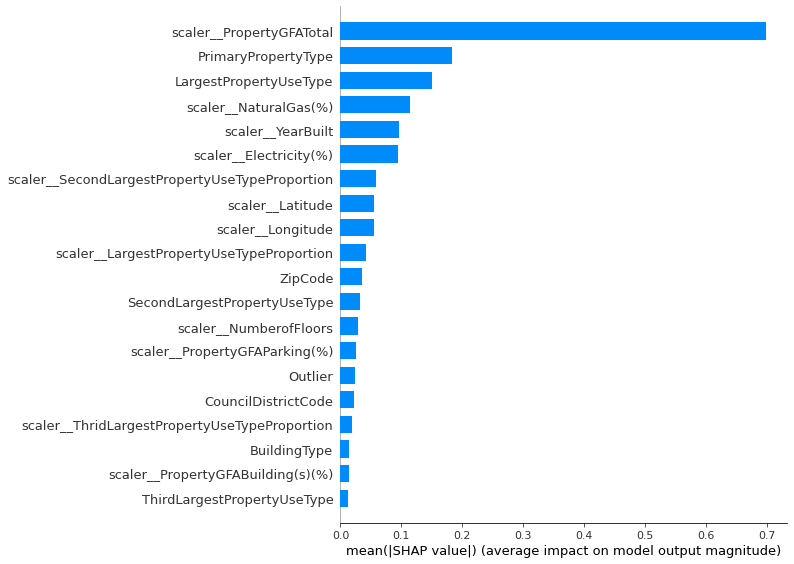

In [68]:
shap.summary_plot(shap_values2, X_test2, feature_names =shap_df.columns, plot_type="bar")

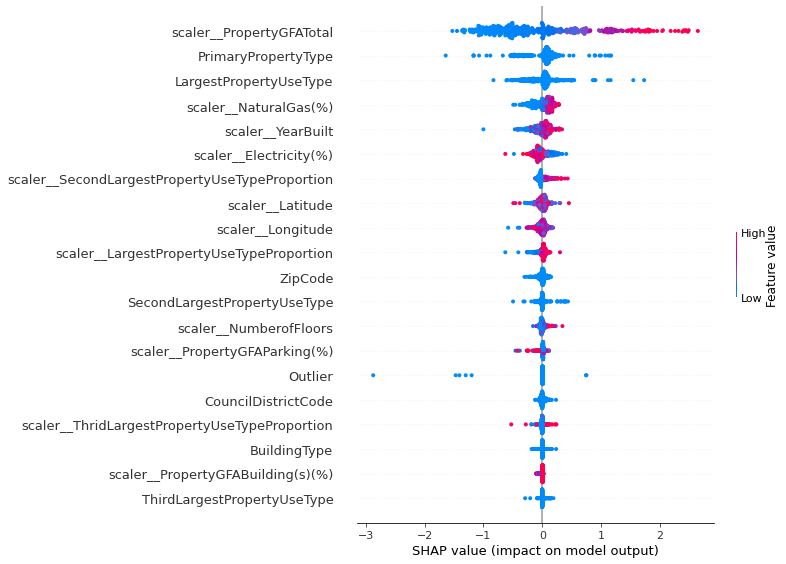

In [69]:
shap.summary_plot(shap_values2, X_test2,feature_names =shap_df.columns)

<code style="background:lightyellow;color:black">retour au <a href="#C0">Sommaire</a></code>


# <div class="alert alert-block alert-info"><a name="C7">7. Impact des propriétés présentes pour 2015 et 2016 pour la prédiction</a></div>

Lors de l'analyse exploratoire, il est apparu qu'une part importante des bâtiments étaient les mêmes pour le jeu de données de 2015 et 2016. Jusqu'à présent, la modèlisation a été réalisé avec ces "doublons". Dans cette partie, je souhaite vérifier si mon modèle est toujours performant si seulement une de deux valeur est gardée pour ces propriétés.

In [70]:
# Chargement du jeu de données où les doublons sont supprimés
data = pd.read_csv('data_pour_model2.csv', index_col = 0)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,...,LargestPropertyUseTypeProportion,SecondLargestPropertyUseTypeProportion,ThridLargestPropertyUseTypeProportion,SiteEnergyUse(log(kBtu)),Electricity(%),NaturalGas(%),SteamUse(%),OtherFuelUse(%),PropertyGFAParking(%),PropertyGFABuilding(s)(%)
1,1,NonResidential,Hotel,7,1927,1,12,88434.0,Hotel,Without,...,100.000000,0.000000,0.000000,15.793246,54.605993,17.663838,27.730162,0.0,0.000000,100.000000
3,2,NonResidential,Hotel,7,1996,1,11,103566.0,Hotel,Parking,...,80.991831,14.545314,4.462855,15.942305,38.660907,61.339093,0.000000,0.0,14.545314,85.454686
5,3,NonResidential,Hotel,7,1969,1,41,956110.0,Hotel,Without,...,79.121963,0.000000,0.000000,18.100297,68.230741,2.057944,29.711308,0.0,20.574829,79.425171
7,5,NonResidential,Hotel,7,1926,1,10,61320.0,Hotel,Without,...,100.000000,0.000000,0.000000,15.731636,40.751928,26.656717,32.591344,0.0,0.000000,100.000000
11,9,Nonresidential COS,Other,7,1999,1,2,97288.0,Public service,Without,...,91.306225,0.000000,0.000000,16.307609,60.988402,39.011598,0.000000,0.0,38.234931,61.765069


In [71]:
# Pour faciliter l'étape de modélisation, je vais attribuer le dtype 'object' au variable qualitative
data[[ 'CouncilDistrictCode', 'ZipCode']] = data[['CouncilDistrictCode', 'ZipCode']].astype(object)

# Suppression de l'ENERGYSTAR Score et de 'OSEBuildingID' pour la prédiction
data_sans = data.drop(columns=['ENERGYSTARScore', 'OSEBuildingID'], axis=1)

print("A présent le jeu de données contient", data_sans.shape[0], "lignes et", data_sans.shape[1], "colonnes")

A présent le jeu de données contient 1311 lignes et 31 colonnes


In [72]:
# Création d'un set de données pour les modèles de machine learning
data_model = data_sans[['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'YearBuilt', 
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
        'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'ZipCode', 'NumberOfUse', 'NumberofBuildings',
       'LargestPropertyUseTypeProportion',
       'SecondLargestPropertyUseTypeProportion',
       'ThridLargestPropertyUseTypeProportion',
       'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)', 'OtherFuelUse(%)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)']]

y_set = data_sans['SiteEnergyUse(log(kBtu))']

X_set = data_model

print("Taille de X_set:", X_set.shape)
print("Taille de y_set_emissions:", y_set.shape)

Taille de X_set: (1311, 26)
Taille de y_set_emissions: (1311,)


In [73]:
# Encodage et standardisation des données
colonne_encodage = list(X_set.dtypes[X_set.dtypes == object].index)
colonne_standardisation = list(X_set.dtypes[X_set.dtypes != object].index)

preprocessing = make_column_transformer((RobustScaler(), colonne_standardisation),
                                       (OneHotEncoder(),colonne_encodage))


X_set_std = preprocessing.fit_transform(X_set)

In [74]:
# Séparation du training set du testing set
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X_set_std, y_set, train_size = 0.8, random_state=123)

print("Taille des training sets X / y: ",X_train_em.shape,"/", y_train_em.shape)
print("Taille des testing sets X / y: ",X_test_em.shape,"/", y_test_em.shape)

Taille des training sets X / y:  (1048, 164) / (1048,)
Taille des testing sets X / y:  (263, 164) / (263,)


In [75]:
parameters = {
    'gamma':[0, 0.5, 1],
    'max_depth': [6, 10, 20],
    'n_estimators' : [100,1000,2000]
}

In [76]:
xgb = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        cv = 5,
                        verbose=False)

start_time = time.time()
xgb.fit(X_train_em, y_train_em)
end_time= time.time()
fitting_time = end_time - start_time

In [77]:
# Prédiction sur le jeu de données test
y_pred = xgb.predict(X_test_em)


# Evaluation du modèle
print("Méthode: Xgboost")

score_ent =xgb.score(X_train_em,y_train_em)
print("Score d'entrainement = ", score_ent)

score_pred = xgb.score(X_test_em, y_test_em)
print("score de la prédiction = ",  score_pred), 

mae = mean_absolute_error(y_test_em,y_pred)
print("MAE = ",mae)

rmse = np.sqrt(mean_squared_error(y_test_em,y_pred))
print("RMSE = ",rmse)

r2 = r2_score(y_test_em,y_pred)
print("R2 = ", r2)

print("Durée de calcul = ", fitting_time )

Méthode: Xgboost
Score d'entrainement =  0.9017016096731874
score de la prédiction =  0.7837767743587765
MAE =  0.49467108252214
RMSE =  0.643341310067056
R2 =  0.7837767743587765
Durée de calcul =  470.6840126514435


En gardant les relevés que pour une des deux années, le score de la prédiction est plus faible puisqu'il passe de 92,2% à 78,4%. Ce score reste toutefois assez intéressant.